# Language features

Compare language families by features

In [9]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
# Read all filenames in the language_features directory, filter out non-csv files
import os
filenames = os.listdir('language_features')
filenames = [filename for filename in filenames if filename.endswith('.csv')]
# Read csv for each language
languages = []
for filename in filenames:
    lang = pd.read_csv('language_features/' + filename, sep='\t', index_col=False)
    # Add a column for the language and family
    family = filename.split('-')[0]
    # Uppercase first letter of family name
    family = family[0].upper() + family[1:]
    if family == 'Baltoslavic':
        family = 'Balto-Slavic'
    language = filename.split('-')[1].replace('.csv', '')
    lang['language'] = language
    lang['family'] = family
    languages.append(lang)
# Concatenate all languages into one dataframe
lang = pd.concat(languages, ignore_index=True)
lang


,Fid,Value,Feature,Reference,Area,language,family
0,1A,Average,Consonant Inventories,Cheng 1973a; Dow 1972; Hanyu 1960; Chao 1968,Phonology,mandarin,Sinitic
1,2A,Average (5-6),Vowel Quality Inventories,Cheng 1973a; Dow 1972; Hanyu 1960; Chao 1968,Phonology,mandarin,Sinitic
2,3A,Average,Consonant-Vowel Ratio,Cheng 1973a; Dow 1972; Hanyu 1960; Chao 1968,Phonology,mandarin,Sinitic
3,4A,In fricatives alone,Voicing in Plosives and Fricatives,Cheng 1973a; Dow 1972; Hanyu 1960; Chao 1968,Phonology,mandarin,Sinitic
4,5A,Other,Voicing and Gaps in Plosive Systems,Cheng 1973a; Dow 1972; Hanyu 1960; Chao 1968,Phonology,mandarin,Sinitic
...,...,...,...,...,...,...,...
2959,143G,None,Minor morphological means of signaling negation,Partridge 1964: 31,Word Order,croatian,Balto-Slavic
2960,144A,Other,Position of Negative Word With Respect to Subj...,Partridge 1964: 31,Word Order,croatian,Balto-Slavic
2961,144D,Other NegV,The Position of Negative Morphemes in SVO Lang...,Partridge 1964: 31,Word Order,croatian,Balto-Slavic
2962,144J,No SVNegO,SVNegO Order,Partridge 1964: 31,Word Order,croatian,Balto-Slavic


In [11]:
def tidy_feature_name(feature):
    feature = feature.replace('(','').replace(')','').replace('\'','')
    feature_parts = feature.split('~')
    feature = feature_parts[0].strip() + ': ' + feature_parts[1].strip() + ' (' + feature_parts[2].strip() + ')'
    # Count the number of space characters
    num_spaces = feature.count(' ')
    # Find the position of nth occurence of space
    pos = [pos for pos, char in enumerate(feature) if char == ' '][num_spaces//2]
    # Insert a newline character after the nth space
    feature = feature[:pos] + '\n' + feature[pos+1:]
    return feature

# Function to get features from one language
def get_features(language):
    features = lang[lang['language'] == language][['Feature', 'Value', 'Area']]
    features = features.apply(lambda x: '~'.join([str(item) for item in tuple(x)]), axis=1).unique()
    # Remove brackets from all features
    features = [tidy_feature_name(feature) for feature in features]
    return features

def get_all_features(languages):
    features = []
    for language in languages:
        features.extend(get_features(language))
    features = np.unique(features)
    return features

# Function to get features from a list of languages
def get_common_features(languages):
    features = get_all_features(languages)
    for language in languages:
        language_features = get_features(language)
        features = np.intersect1d(features, language_features)
    return features

# Function to get features in common between a language family
def get_shared_features_family(family):
    features = get_common_features(lang[lang['family'] == family]['language'].unique())
    return features

# Function to get features in common between a language family
def get_all_features_family(family):
    features = get_all_features(lang[lang['family'] == family]['language'].unique())
    return features

# Function to get features in common between two language families
def get_features_in_common(family1, family2):
    family1_features = get_shared_features_family(family1)
    family2_features = get_shared_features_family(family2)
    features = np.intersect1d(family1_features, family2_features)
    return features

# Function to get features unique to a language family
def get_features_unique(family1, family2):
    family1_features = get_shared_features_family(family1)
    family2_features = get_all_features_family(family2)
    features = np.setdiff1d(family1_features, family2_features)
    return features

# Get features in common between germanic, romance, chinese and baltoslavic languages
germanic_features = get_shared_features_family('germanic')
romance_features = get_shared_features_family('romance')
chinese_features = get_shared_features_family('chinese')
baltoslavic_features = get_shared_features_family('baltoslavic')
other_features = get_shared_features_family('other')



In [12]:
get_features_unique('Germanic', 'Italic')

array(['Order of Adjective and\nNoun: Adjective-Noun (Word Order)'],
      dtype='<U144')

## Predict DYMULTICUE LF Performance from Language Feature

In [14]:
model_scores = pd.read_csv('multilingual_lexicon_averages.csv', sep=',', index_col=False)
# Lowercase all languages
model_scores['Language'] = model_scores['Language'].str.lower()
# Get DYMULTI-22 type_fscore
dymulti_scores = model_scores[model_scores['Model'] == 'DYMULTI-23']
dymulti_scores = dymulti_scores[['Language', 'type_fscore']]
dymulti_scores = dymulti_scores.set_index('Language').T.to_dict('list')
dymulti_scores = {k: v[0] for k, v in dymulti_scores.items()}

In [17]:
languages = lang['language'].unique()
all_features = get_all_features(languages)
language_features = {}
for feature in all_features:
    language_features[feature] = {}
language_features['type_fscore'] = {}
language_features['family'] = {}

for language in languages:
    features = get_features(language)
    for feature in all_features:
        if feature in features:
            language_features[feature][language] = 1
        else:
            language_features[feature][language] = 0
    language_features['type_fscore'][language] = dymulti_scores[language]
    language_features['family'][language] = lang[lang['language'] == language]['family'].unique()[0]
data = pd.DataFrame(language_features)
data.head()

# Name index column 'language'
data.index.name = 'language'

# Copy data to new dataframe
data2 = data.copy()
type_fscore = data2['type_fscore']
family = data2['family']
data2 = data2.drop(columns=['type_fscore', 'family'])
data2 = data2.stack().reset_index()
data2 = data2.rename(columns={"level_1" : "Feature", 0: 'Feature Present?'})
# Add type_fscore and family back to dataframe
data2['type_fscore'] = data2['language'].map(type_fscore)
data2['Family'] = data2['language'].map(family)
data2.head()


,language,Feature,Feature Present?,type_fscore,Family
0,mandarin,Absence of Common Consonants:\nAll present (Ph...,1,71.649984,Sinitic
1,mandarin,Action Nominal Constructions:\nDouble-Possessi...,0,71.649984,Sinitic
2,mandarin,Action Nominal Constructions:\nErgative-Posses...,0,71.649984,Sinitic
3,mandarin,Action Nominal Constructions:\nMixed (Nominal ...,0,71.649984,Sinitic
4,mandarin,Action Nominal Constructions:\nOther (Nominal ...,0,71.649984,Sinitic


In [18]:
X = data[all_features]
y = data['type_fscore']

# Convert datatype of X headings to string
X.columns = X.columns.astype(str)

# Find which features in X predict y

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression, chi2

# feature extraction
test = SelectKBest(score_func=f_regression, k=10)
fit = test.fit_transform(X, y)

best_features = test.get_feature_names_out(all_features)

/opt/homebrew/Caskroom/miniforge/base/envs/wordseg/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/Caskroom/miniforge/base/envs/wordseg/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


In [21]:
# Filter data2 by best features
plot_data = data2[data2['Feature'].isin(best_features)]
plot_data.head()

,language,Feature,Feature Present?,type_fscore,Family
48,mandarin,Comparative Constructions: Locational\n(Simple...,0,71.649984,Sinitic
70,mandarin,Distributive Numerals: Marked by\nsuffix (Nomi...,0,71.649984,Sinitic
73,mandarin,Ditransitive Constructions: The Verb Give:\nIn...,0,71.649984,Sinitic
208,mandarin,Order of Adposition and Noun\nPhrase: Postposi...,0,71.649984,Sinitic
212,mandarin,Order of Adverbial Subordinator and Clause:\nF...,0,71.649984,Sinitic


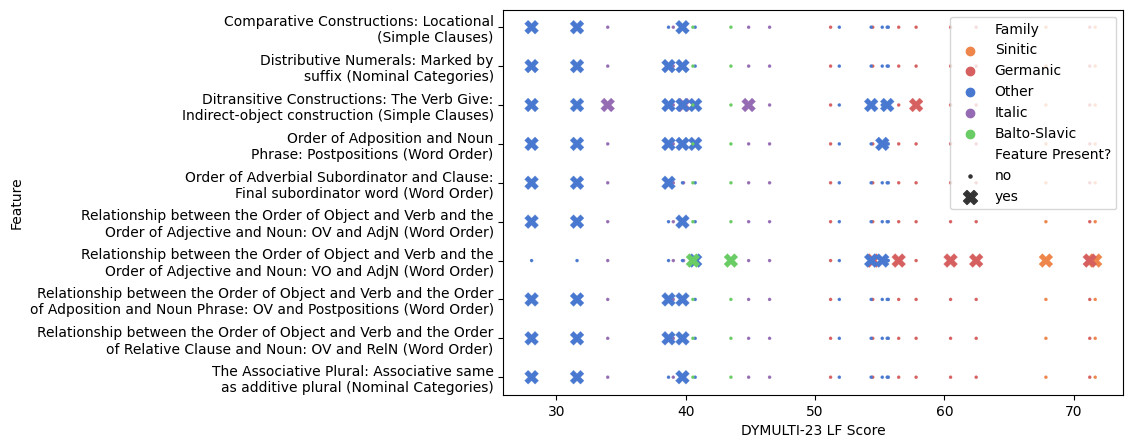

In [22]:
colors = sns.color_palette('muted', n_colors=5, as_cmap=True)
family_language_map = {'Other' : colors[0], 'Italic' : colors[4], 'Germanic' : colors[3], 'Balto-Slavic' : colors[2], 'Sinitic' : colors[1]}

# Set size of plot
plt.figure(figsize=(8, 5))
sns.scatterplot(y='Feature', x='type_fscore', data=plot_data, hue='Family', palette=family_language_map, style = 'Feature Present?', marker='x', legend='full', size='Feature Present?', sizes = (5, 100), size_norm = (0, 1))
plt.xlabel('DYMULTI-23 LF Score')
plt.ylabel('Feature')
# Use two lines for each y axis label
plt.yticks(np.arange(0, len(best_features), 1), best_features, rotation=0)

handles, labels = plt.gca().get_legend_handles_labels()
labels[7] = 'no'
labels[8] = 'yes'
# Split legend into two columns
plt.legend(handles, labels, loc='upper right')

plt.show()



In [23]:
# Filter indo-european languages
indo_european = ['swedish', 'german', 'portuguese', 'danish', 'french', 
                'spanish', 'italian', 'norwegian', 'serbian', 
                'dutch', 'icelandic', 'english', 'romanian', 'croatian']
data3 = data[data.index.isin(indo_european)]


X = data3[all_features]
y = data3['type_fscore']

# Convert datatype of X headings to string
X.columns = X.columns.astype(str)

# feature extraction
test = SelectKBest(score_func=f_regression, k=10)
fit = test.fit_transform(X, y)

best_features = test.get_feature_names_out(all_features)

/opt/homebrew/Caskroom/miniforge/base/envs/wordseg/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/Caskroom/miniforge/base/envs/wordseg/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/Caskroom/miniforge/base/envs/wordseg/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


In [26]:
# Filter data2 by indo-european languages and best features
plot_data = data2[data2['language'].isin(indo_european)]
plot_data = plot_data[plot_data['Feature'].isin(best_features)]
plot_data.head()

,language,Feature,Feature Present?,type_fscore,Family
594,swedish,Expression of Pronominal Subjects: Obligatory ...,1,54.456192,Germanic
596,swedish,Expression of Pronominal Subjects: Subject\naf...,0,54.456192,Germanic
716,swedish,Order of Adjective and\nNoun: Adjective-Noun (...,1,54.456192,Germanic
717,swedish,Order of Adjective and\nNoun: Noun-Adjective (...,0,54.456192,Germanic
735,swedish,Order of Negative Morpheme and Verb: Type\n1 /...,1,54.456192,Germanic


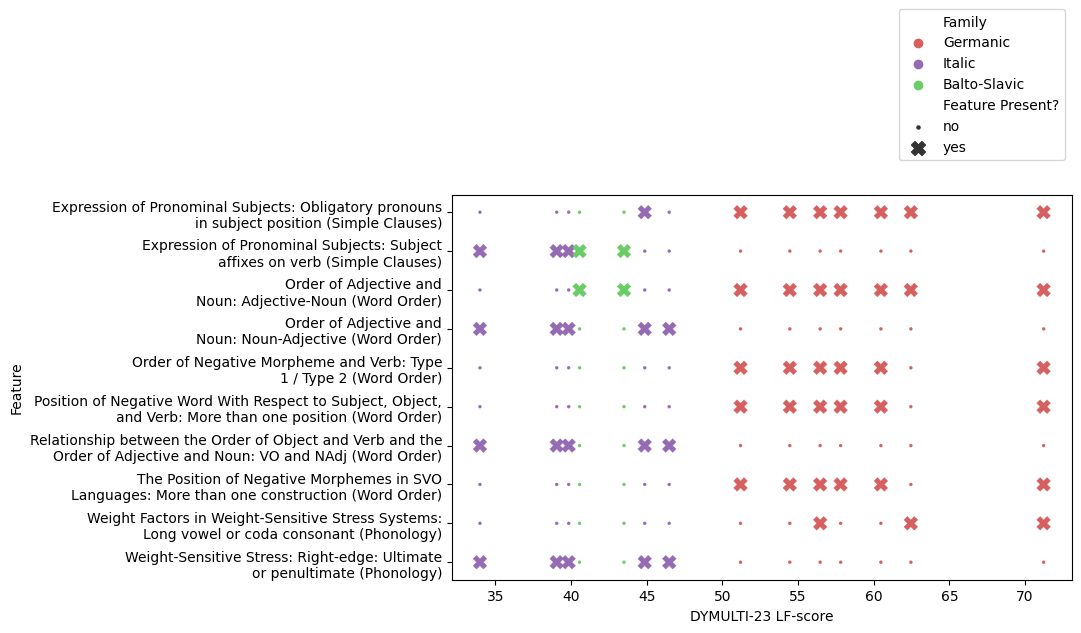

In [29]:
plt.figure(figsize=(8, 5))
sns.scatterplot(y='Feature', x='type_fscore', data=plot_data, hue='Family', palette=family_language_map, style = 'Feature Present?', marker='x', legend='full', size='Feature Present?', sizes = (5, 100), size_norm = (0, 1))
plt.xlabel('DYMULTI-23 LF-score')
plt.ylabel('Feature')
# Use two lines for each y axis label
plt.yticks(np.arange(0, len(best_features), 1), best_features, rotation=0)

handles, labels = plt.gca().get_legend_handles_labels()
labels[5] = 'no'
labels[6] = 'yes'
# Put legend outside of plot
plt.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1.5))

plt.show()

In [ ]:
print(len(all_features))
print(len([feature for feature in all_features if 'Word Order' in feature]))

NameError: name 'all_features' is not defined